In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [3]:
#importing neccessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [4]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used.')
else:
    print('GPU is not being used.')

GPU is being used.


In [5]:
#PATH TO THE DATASET
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

#list all the classes(animal types)
classes = os.listdir(dataset_path)
num_classes = len(classes)

#display the number of classes along with numbers
print(f"Number of classes:{num_classes}")
print(f"classes:{classes}")



Number of classes:90
classes:['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


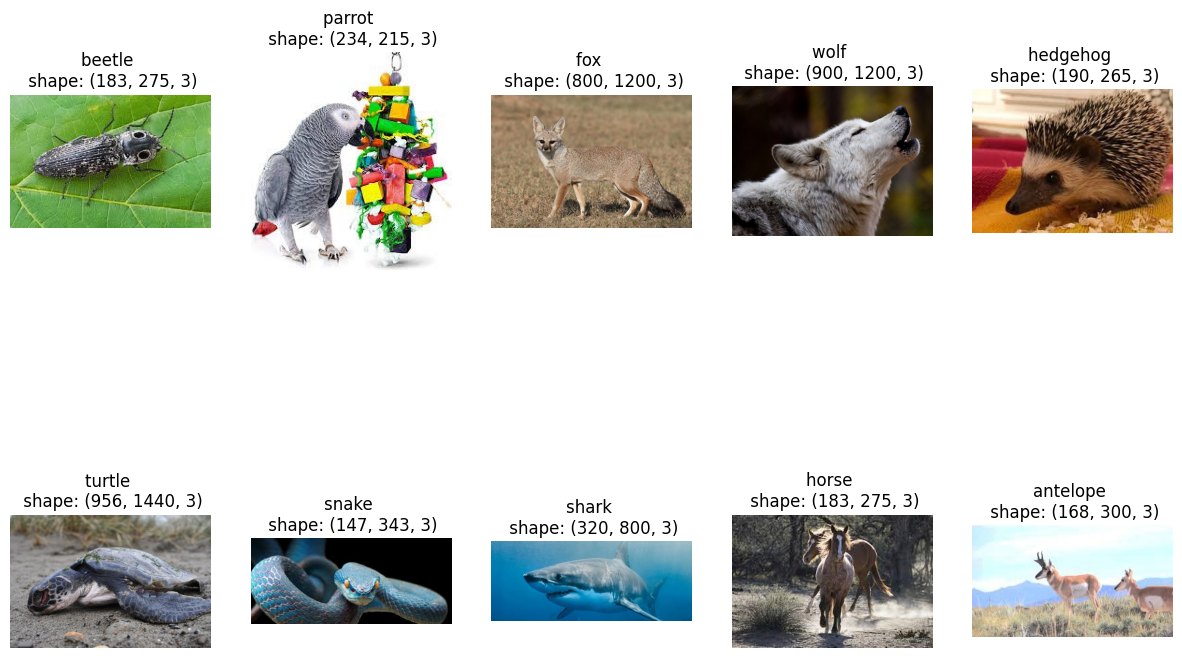

In [6]:
#visualize some sample images from the dataset
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
   class_path = os.path.join(dataset_path, class_name)
   img_name = os.listdir(class_path)[0]
   img_path = os.path.join(class_path, img_name)
   img = plt.imread(img_path)

   plt.subplot(2, 5, i+1)
   plt.imshow(img)
   plt.title(f'{class_name} \n shape: {img.shape}')
   plt.axis('off')
   plt.tight_layout

In [7]:
#preprocessing the data
#define image size and batch_size - Trained model - MobileNetV2 - 224 x 224
img_size = (224, 224)
batch_size = 64 # there can be 64 images in a batch

#data Arguementation and prepocessing
datagen = ImageDataGenerator(
    rescale=1./225,
    validation_split=0.1
)

#create training and validation generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical' ,
    subset='training'
)

validation_generator  = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [8]:
#map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)
#extract class names
class_names = list(class_indices.keys())
print("class_names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [9]:
# load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights = 'imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model weights, training
base_model.trainable =False

# Add custom layers on top of the base model GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation= 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)#outputlayer

# Create the final model
model = Model(inputs=base_model.input,outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crosentrophy',
              metrics = ['accuracy'])

# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy', # Corrected the loss function name
              metrics = ['accuracy'])
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples  // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples  // batch_size,
    epochs = 20
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.3412 - loss: 3.1046

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.3437 - loss: 3.0908 - val_accuracy: 0.7793 - val_loss: 0.7766
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6250 - loss: 1.3056

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.6250 - loss: 1.3056 - val_accuracy: 0.7734 - val_loss: 0.7859
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 90s 547ms/step - accuracy: 0.8137 - loss: 0.6414 - val_accuracy: 0.8398 - val_loss: 0.5975
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8594 - loss: 0.5612 - val_accuracy: 0.8477 - val_loss: 0.5808
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8988 - loss: 0.3557 - val_accuracy: 0.8496 - val_loss: 0.5488
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8594 - loss: 0.3594 - val_accuracy: 0.8398 - val_loss: 0.5499
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9378 - loss: 0.2168 - val_accuracy: 0.8574 - val_loss: 0.5283
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8750 - loss: 0.3234 - val_accuracy: 0.8438 - val_loss: 0.5346
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9563 - loss: 0.1651 - val_accuracy: 0.8555 - val_loss: 0.5

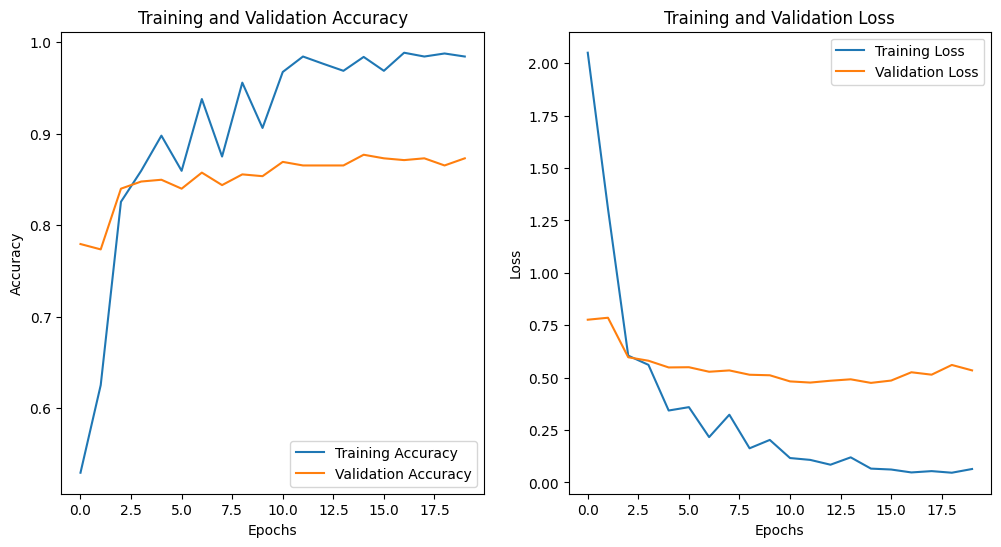

In [16]:
# Evaluate the model - plotting the training and validation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [13]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 858ms/step - accuracy: 0.8833 - loss: 0.5148
Validation Loss: 0.546326756477356
Validation Accuracy: 0.8722222447395325


In [14]:
# Save the model
model.save('MCAR.keras')

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

loaded_model = load_model('MCAR.keras')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction)

    plt.imshow(img)
    plt.title(f"Predicted Class: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

In [18]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot')

['5affc48d37.jpg',
 '4aba5914cd.jpg',
 '3ac69be3f6.jpg',
 '29c26708a0.jpg',
 '96c5e35a54.jpg',
 '60e0c50a4a.jpg',
 '27a9ce4e1a.jpg',
 '64bd254fef.jpg',
 '46ed4828b1.jpg',
 '3a0c5d4582.jpg',
 '6a0ab0de34.jpg',
 '84b6622dbc.jpg',
 '6be2eb3fb3.jpg',
 '1bcd666a4e.jpg',
 '87bc6bdcd7.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '7a7fdb0450.jpg',
 '9d0d266d23.jpg',
 '8f5a2730b3.jpg',
 '4c26cd72e2.jpg',
 '4faf55514e.jpg',
 '2f207b75e3.jpg',
 '56b19e9dbc.jpg',
 '1dd93e1004.jpg',
 '66e79b1a2f.jpg',
 '34f9668c8e.jpg',
 '3de507dbb6.jpg',
 '0b29c10342.jpg',
 '64c08f053c.jpg',
 '060cca8826.jpg',
 '036b760476.jpg',
 '46c1b71d00.jpg',
 '8cdc657d99.jpg',
 '61def3553e.jpg',
 '0100ec7408.jpg',
 '8a8a69d934.jpg',
 '7d5cb5f5fa.jpg',
 '47ef39ceb6.jpg',
 '7dab3a1142.jpg',
 '46de4406fb.jpg',
 '6a184a05f3.jpg',
 '89d679b9e5.jpg',
 '0f072e6ce1.jpg',
 '0d778c6833.jpg',
 '0b2a1e349a.jpg',
 '3f5e9e225b.jpg',
 '4af25ae32d.jpg',
 '1cabf8a760.jpg',
 '5b1030ddd5.jpg',
 '91f0604cc7.jpg',
 '080a286cf3.jpg',
 '50e40b5356

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


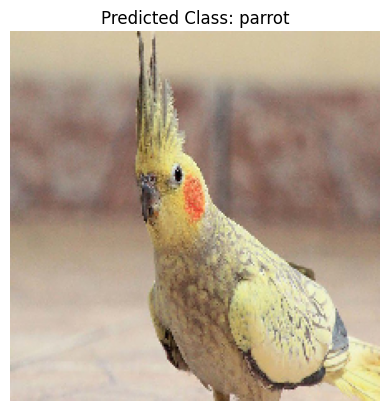

In [19]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot/9c2dd51734.jpg')